# Add a constant $r_s$ line to the Skew-T - ln P plot

Demonstrate how to construct dry adiabats and isotherms for
a thermodynamic diagram using the functions in
[makeSkew.py](https://github.com/phaustin/A405/blob/master/a405skewT/makeSkew.py)

In [1]:
import numpy as np
import pandas as pd
import h5py
from pprint import pformat
from a405thermo.constants import constants as c
from a405skewT.makeSkew import makeSkewDry
from a405thermo.thermlib import convertSkewToTemp, convertTempToSkew

In [2]:
filename='littlerock.h5';
print('reading file: %s\n' %filename)

attributes={}
with h5py.File(filename,'r') as f:
    keys=f.attrs.keys()
    for key in keys:
        try:
            attributes[key]=f.attrs[key]
        except IOError:
            print('empty key: ',key)
print('\nread in these attributes: \n\n',pformat(attributes))

separator= '\n' + '+'*30 + '\n'
sounding_dict={}
with pd.HDFStore(filename,'r') as store:
    times=store.keys()
    for the_time in times:
        sounding_dict[the_time]=store[the_time]
sounding=sounding_dict[times[3]]
print('{0:}sounding times:{1:}{0:} '.format(separator,times))
print('{0:}columns: {1:}{0:} '.format(separator,pformat(sounding.columns)))
title_string=attributes['header']
index=title_string.find(' Observations at')
location=title_string[:index]
title='{} at {}'.format(location,times[0][2:])
print('title: :',title)
units=attributes['units'].split(';')
units_dict={}
for count,var in enumerate(sounding.columns):
    units_dict[var]=units[count]
print('variables with units: \n',pformat(units_dict))

reading file: littlerock.h5

empty key:  TITLE
empty key:  CLASS
empty key:  VERSION
empty key:  PYTABLES_FORMAT_VERSION

read in these attributes: 

 {'elevation': 1.0,
 'header': '72340 LZK Little Rock Observations at 00Z 01 Mar 2012',
 'history': 'written by test_requests.py',
 'latitude': 34.829999999999998,
 'longitude': -92.269999999999996,
 'site_id': '72340',
 'units': 'hPa;m;C;C;%;g/kg;deg;knot;K;K;K'}

++++++++++++++++++++++++++++++
sounding times:['/Y2012_Mar_01_00Z', '/Y2012_Mar_01_12Z', '/Y2012_Mar_02_00Z', '/Y2012_Mar_02_12Z', '/Y2012_Mar_02_18Z', '/Y2012_Mar_03_00Z', '/Y2012_Mar_03_12Z', '/Y2012_Mar_04_00Z', '/Y2012_Mar_04_12Z', '/Y2012_Mar_05_00Z', '/Y2012_Mar_05_12Z', '/Y2012_Mar_06_00Z', '/Y2012_Mar_06_12Z', '/Y2012_Mar_07_00Z', '/Y2012_Mar_07_12Z', '/Y2012_Mar_08_00Z', '/Y2012_Mar_08_12Z', '/Y2012_Mar_09_00Z', '/Y2012_Mar_09_12Z', '/Y2012_Mar_10_00Z', '/Y2012_Mar_10_12Z', '/Y2012_Mar_11_00Z', '/Y2012_Mar_11_12Z', '/Y2012_Mar_12_00Z', '/Y2012_Mar_12_12Z', '/Y2012_Mar_

In [3]:
fig,ax =plt.subplots(1,1,figsize=(8,8))
ax,skew = makeSkewDry(ax)
triplets=zip(sounding['temp'],sounding['dwpt'],sounding['pres'])
xcoord_T=[]
xcoord_Td=[]
for a_temp,a_dew,a_pres in triplets:
    xcoord_T.append(convertTempToSkew(a_temp,a_pres,skew))
    xcoord_Td.append(convertTempToSkew(a_dew,a_pres,skew))
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')

#
#  make the last two lines added to the plot (temp and dewpoint)
#  thicker
#
[line.set(linewidth=3) for line in ax.lines[-2:]]
out=ax.set(title=title)

### For Wednesday 9am

Check in a notebook that puts your sounding on the tephigram and draws a line of constant saturation mixing ratio 
$r_s$ = 10 g/kg between 1000 and  400 hPa.  

Hint -- you want to rootfind the temperature that satisfies Thompkins (2.20):

$$r_s = \frac{\epsilon e_s(T)}{p - e_s(T)} = 0.01\ kg/kg$$

for a range of pressures then convert the temperatures to skew coordinates.

In [4]:
from importlib import reload
import a405thermo.thermlib
reload(a405thermo.thermlib)
from a405thermo.thermlib import find_esat

def zero_rs(temp,rsat,press):
    """
      find the saturation temperature for 
      a given rsat,press, by rootfinding this zero
      
      input: temp (guess) (K)
             rsat (kg/kg)
             press (hPa)
      output: residual
      
      see thompkins 2.20
     
    """
    esat=find_esat(temp)*0.01  #convert to hPa
    residual=rsat - c.eps*esat/(press - esat)
    return residual

def find_rsat(temp,press):
    """
       input: temp (K)
              press (hPa)
        output: rsat (kg/kg)
    """
    esat = find_esat(temp)*0.01
    rsat=c.eps*esat/(press - esat)
    return rsat

def zero_find_rs(tstart,rsat,press):
    """
       find the temp that produces rsat at press.
       input: temp (K)
              rsat (kg/kg)
              press (hPa)
        output: temp (K)
    """
    brackets=rf.find_interval(zero_rs,tstart,rsat,press)
    temp = rf.fzero(zero_rs,brackets,rsat,press)
    return temp

In [5]:
from a405thermo import rootfinder as rf
temp=273.15
press=800.
rsat=1.e-2
brackets=rf.find_interval(zero_rs,temp,rsat,press)
print('brackets for root: ',brackets)
the_temp=zero_find_rs(temp,rsat,press)
print('dewpoint for rsat = {} g/kg is {:5.2f} K'.format(rsat*1.e3,the_temp))
check_rsat=find_rsat(the_temp,press)
print('rsat for temp={} K, press={} hPa is: {:5.2f} g/kg'.format(temp,press,check_rsat*1.e3))

brackets for root:  (262.22399999999999, 284.07599999999996)
dewpoint for rsat = 10.0 g/kg is 283.61 K
rsat for temp=273.15 K, press=800.0 hPa is: 10.00 g/kg


In [6]:
pressvals=np.linspace(400,1000.,30)  #hPa
tstart=273.  #K
rsat= 10.e-3  #kg/kg
temps=[zero_find_rs(tstart,rsat,the_press) for the_press in pressvals]
temps_tc=np.array(temps) - c.Tc

In [7]:
xcoord_rs=[]
for a_temp,a_press in zip(temps_tc,pressvals):
    out=convertTempToSkew(a_temp,a_press,skew)
    xcoord_rs.append(out)
rs_10=ax.plot(xcoord_rs,pressvals,color='r',label='rsat',linewidth=3.)
display(fig)

## Add a moist adiabat

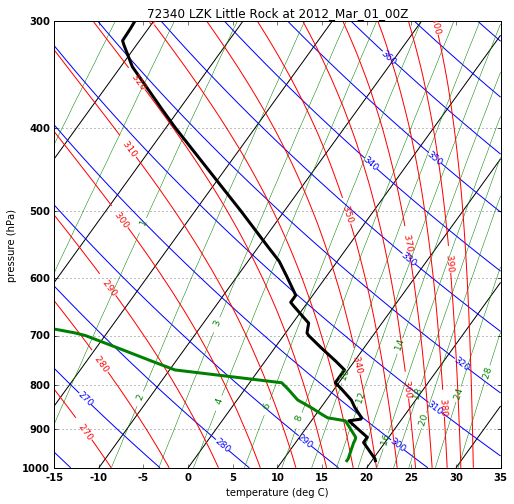

In [8]:
%matplotlib inline
import a405skewT.makeSkewII
reload(a405skewT.makeSkewII)
from a405skewT.makeSkewII import makeSkewWet,find_corners
plt.close('all')
fig,ax =plt.subplots(1,1,figsize=(8,8))
corners=[-15,35]
ax,skew = makeSkewWet(ax,corners=corners,skew=skew)
ax.plot(xcoord_T,sounding['pres'],color='k',label='temp')
ax.plot(xcoord_Td,sounding['pres'],color='g',label='dew')
[line.set(linewidth=3) for line in ax.lines[-2:]]
out=ax.set(title=title)


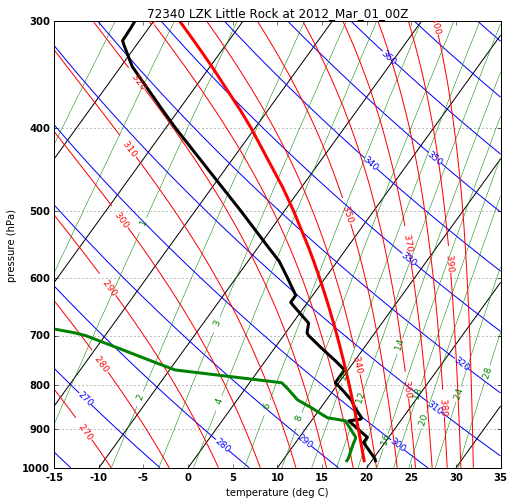

In [9]:
from a405thermo.thermlib import find_Tmoist
thetae=335.
temps= np.array([find_Tmoist(thetae,press*100.) for press in sounding['pres']])
temps = temps - c.Tc
xcoord_thetae=[]
for a_temp,a_press in zip(temps,sounding['pres']):
    out=convertTempToSkew(a_temp,a_press,skew)
    xcoord_thetae.append(out)
ax.plot(xcoord_thetae,sounding['pres'],color='r',label='rsat',linewidth=3.)
display(fig)                                   